In [2]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
os.chdir('gdrive/My Drive/home/qminers')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from qminers.utils import prepare_data_v1

prepare_data = prepare_data_v1

In [0]:
%load_ext autoreload

### Load and prepare data

In [0]:
%autoreload

financial_df = pd.read_csv('data/sp500_2010_01_01-2014_07_31.csv')
calendar_df = pd.read_csv('data/econ_calendar.csv')

data_train_val, data_test = prepare_data(financial_df, calendar_df)

In [0]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(data_train_val, test_size=0.2, shuffle=False)

# Normalize data

- normalize to [0, 1]
- with clipping?

In [0]:
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler

scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()
scaler.fit(data_train)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


MinMaxScaler(copy=True, feature_range=(0, 1))

In [0]:
def transform_data(data, scaler):
  res = scaler.transform(data)
  res = res.clip(0, 1)
  return res

data_train_transformed = transform_data(data_train_val, scaler)
data_val_transformed = transform_data(data_val, scaler)
data_test_transformed = transform_data(data_test, scaler)

# Simplest RNN

In [0]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy


In [0]:
batch_size = 32
sequence_length = 10
lstm_dim = 1

return_sequences = False

In [0]:
# taken from https://www.kaggle.com/c/mercedes-benz-greener-manufacturing/discussion/34019
# custom R2-score metrics for keras backend
from tensorflow.keras import backend as K

def r2_keras(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )
#     return SS_res/(SS_tot + K.epsilon())

In [0]:
def create_lstm_model(lstm_dim, sequence_length, data_dim, lr=1e-4):
  inputs = Input(shape=(sequence_length, data_dim,), name='input')

  output = LSTM(lstm_dim, return_sequences=return_sequences)(inputs)
  output = Dense(1)(output)
  
  model = Model(inputs=inputs, outputs=output)
  model.compile(loss='mae',
                optimizer=Adam(lr=lr),
                metrics=[r2_keras, 'mse'])

  model.summary()
  print("lr=%f" % lr)
  return model


def get_data_generator(data, batch_size, sequence_length, shuffle=True):
  batch_x = np.zeros((batch_size, sequence_length, data.shape[1]))
  if return_sequences:
    batch_y = np.zeros((batch_size, sequence_length, 1))
  else:
    batch_y = np.zeros((batch_size, 1))
    
  while True:
    # -1 because outputs are shifted by +1
    if shuffle:
      # random sample from training data
      rand_inds = np.random.randint(0, data.shape[0] - sequence_length - 1, batch_size)
    else:
      # not random, chronological

      # shift by the whole sequence
  #     step = sequence_length

      # shift by 1 timestep
      step = 1

      stop_ind = min(batch_size * step - 1, data.shape[0] - sequence_length - 1)
      rand_inds = np.arange(start=0, step=step, stop=stop_ind)

    for i, idx in enumerate(rand_inds):
      end_idx = idx + sequence_length
      batch_x[i] = data[idx:end_idx,:]
      
      if return_sequences:
        batch_y[i] = data[idx + 1:end_idx + 1, -1, np.newaxis]
      else:
        batch_y[i] = data[end_idx, -1]

    yield batch_x, batch_y

In [0]:
data_train_val_x, data_train_val_y = next(get_data_generator(data_train_val.values, data_train_val.shape[0] - sequence_length, sequence_length, shuffle=False))

In [0]:
data_train_val_x.shape

(911, 10, 10)

In [0]:
data_train_val_y.shape

(911, 1)

# Prepare GridSearchCV

In [0]:
# inspired in https://stackoverflow.com/questions/50125844/how-to-standard-scale-a-3d-matrix

import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler


class NDScaler(TransformerMixin):
    def __init__(self, scaler, **kwargs):
        self._scaler = scaler(copy=True, **kwargs)
        self._orig_shape_x = None
        self._orig_shape_y = None

    def fit(self, X, y=None, **kwargs):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
          self._orig_shape_x = X.shape[1:]
        
        if y is not None:
          y = np.array(y)
          if len(y.shape) > 1:
            self._orig_shape_y = y.shape[1:]
            
        X, y = self._flatten(X, y)
        
        self._scaler.fit(X, y, **kwargs)
        return self

    def transform(self, X, y=None, **kwargs):
        X = np.array(X)
        
        if y is not None:
          y = np.array(y)
          
        X, y = self._flatten(X, y)
        X = self._scaler.transform(X, y, **kwargs)
        if isinstance(X, tuple):
          X, y = X
        X, y = self._reshape(X, y)
        return X

    def _flatten(self, X, y=None):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape_x)
            X = X.reshape(-1, n_dims)
          
        if y is not None and len(y.shape) > 2:
            n_dims = np.prod(self._orig_shape_y)
            y = y.reshape(-1, n_dims)
          
        return X, y

    def _reshape(self, X, y=None):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape_x)
        
        if y is not None and len(y.shape) >= 2:
            y = y.reshape(-1, *self._orig_shape_y)
        
        return X, y

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV


scaler, regressor, transformer = None, None, None

estimators = [('preprocessing', scaler), ('model', regressor)]
# estimators = [('model', regressor)]
estimators = Pipeline(estimators)

regr = TransformedTargetRegressor(regressor=estimators,
                                   transformer=transformer)

# model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_val_x.shape[2], lr=1e-5)
models = [KerasRegressor(build_fn=create_lstm_model)]

param_grid = {
#     'regressor__preprocessing': [MinMaxScaler(), RobustScaler(), StandardScaler()],
    'regressor__preprocessing': [NDScaler(scaler=StandardScaler)],
    'regressor__model': models,
    'regressor__model__batch_size': [batch_size],
    'regressor__model__lstm_dim': [lstm_dim],
    'regressor__model__sequence_length': [sequence_length],
    'regressor__model__data_dim': [data_train_val_x.shape[2]],
    'regressor__model__lr': [1e-4],
    'regressor__model__epochs': [500],
    'regressor__model__verbose': [2],
#     'regressor__model__verbose': [0],
#     'transformer': [MinMaxScaler(), RobustScaler(), StandardScaler()]
    'transformer': [MinMaxScaler()]
}

grid_search = GridSearchCV(
    cv=10,
    scoring=('r2', 'neg_mean_squared_error'),
    refit='r2',
#     refit=False,
    estimator=regr,
    param_grid=param_grid,
#     return_train_score=True)
    return_train_score=False)

### Standard scaler

In [38]:
grid_search.fit(data_train_val_x, data_train_val_y)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_40 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2778 - r2_keras: -1.1144e+01 - mean_squared_error: 0.1106
Epoch 2/500
 - 0s - loss: 0.2744 - r2_keras: -1.0572e+01 - mean_squared_error: 0.1083
Epoch 3/500
 - 0s - loss: 0.2710 - r2_keras: -1.0986e+01 - mean_squared_error: 0.1058
Epoch 4/500
 - 0s - loss: 0.2677 - r2_keras: -1.0255e+01 - mean_squared_error: 0.1036
Epoch 5/500
 - 0s - loss: 0.2644 - r2_keras: -1.0377e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.4136 - r2_keras: -1.9524e+01 - mean_squared_error: 0.2126
Epoch 2/500
 - 0s - loss: 0.4094 - r2_keras: -1.8719e+01 - mean_squared_error: 0.2086
Epoch 3/500
 - 0s - loss: 0.4053 - r2_keras: -1.9038e+01 - mean_squared_error: 0.2046
Epoch 4/500
 - 0s - loss: 0.4012 - r2_keras: -1.6369e+01 - mean_squared_error: 0.2007
Epoch 5/500
 - 0s - loss: 0.3971 - r2_keras: -1.6814e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_42 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.3971 - r2_keras: -1.9986e+01 - mean_squared_error: 0.2285
Epoch 2/500
 - 0s - loss: 0.3917 - r2_keras: -1.9118e+01 - mean_squared_error: 0.2232
Epoch 3/500
 - 0s - loss: 0.3864 - r2_keras: -1.7942e+01 - mean_squared_error: 0.2182
Epoch 4/500
 - 0s - loss: 0.3811 - r2_keras: -1.8593e+01 - mean_squared_error: 0.2131
Epoch 5/500
 - 0s - loss: 0.3758 - r2_keras: -1.7185e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2263 - r2_keras: -4.5715e+00 - mean_squared_error: 0.0671
Epoch 2/500
 - 0s - loss: 0.2224 - r2_keras: -4.5600e+00 - mean_squared_error: 0.0652
Epoch 3/500
 - 0s - loss: 0.2184 - r2_keras: -4.0138e+00 - mean_squared_error: 0.0633
Epoch 4/500
 - 0s - loss: 0.2144 - r2_keras: -3.8549e+00 - mean_squared_error: 0.0614
Epoch 5/500
 - 0s - loss: 0.2103 - r2_keras: -3.9725e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_44 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2634 - r2_keras: -8.2301e+00 - mean_squared_error: 0.0954
Epoch 2/500
 - 0s - loss: 0.2596 - r2_keras: -8.3979e+00 - mean_squared_error: 0.0931
Epoch 3/500
 - 0s - loss: 0.2558 - r2_keras: -8.4184e+00 - mean_squared_error: 0.0908
Epoch 4/500
 - 0s - loss: 0.2521 - r2_keras: -7.7297e+00 - mean_squared_error: 0.0887
Epoch 5/500
 - 0s - loss: 0.2484 - r2_keras: -7.9459e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_45 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_45 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2532 - r2_keras: -5.0554e+00 - mean_squared_error: 0.0775
Epoch 2/500
 - 0s - loss: 0.2502 - r2_keras: -5.4636e+00 - mean_squared_error: 0.0760
Epoch 3/500
 - 0s - loss: 0.2472 - r2_keras: -5.1451e+00 - mean_squared_error: 0.0745
Epoch 4/500
 - 0s - loss: 0.2443 - r2_keras: -4.8505e+00 - mean_squared_error: 0.0731
Epoch 5/500
 - 0s - loss: 0.2414 - r2_keras: -5.0729e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_46 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_46 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2643 - r2_keras: -5.4272e+00 - mean_squared_error: 0.0838
Epoch 2/500
 - 0s - loss: 0.2604 - r2_keras: -5.7045e+00 - mean_squared_error: 0.0817
Epoch 3/500
 - 0s - loss: 0.2566 - r2_keras: -5.2994e+00 - mean_squared_error: 0.0798
Epoch 4/500
 - 0s - loss: 0.2528 - r2_keras: -5.4679e+00 - mean_squared_error: 0.0778
Epoch 5/500
 - 0s - loss: 0.2491 - r2_keras: -5.1643e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 3s - loss: 0.4594 - r2_keras: -2.1854e+01 - mean_squared_error: 0.2715
Epoch 2/500
 - 0s - loss: 0.4559 - r2_keras: -2.1131e+01 - mean_squared_error: 0.2677
Epoch 3/500
 - 0s - loss: 0.4526 - r2_keras: -2.3068e+01 - mean_squared_error: 0.2641
Epoch 4/500
 - 0s - loss: 0.4491 - r2_keras: -2.1593e+01 - mean_squared_error: 0.2605
Epoch 5/500
 - 0s - loss: 0.4457 - r2_keras: -2.0436e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_48 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2965 - r2_keras: -1.0401e+01 - mean_squared_error: 0.1208
Epoch 2/500
 - 0s - loss: 0.2910 - r2_keras: -8.5393e+00 - mean_squared_error: 0.1167
Epoch 3/500
 - 0s - loss: 0.2856 - r2_keras: -8.9878e+00 - mean_squared_error: 0.1128
Epoch 4/500
 - 0s - loss: 0.2802 - r2_keras: -8.5192e+00 - mean_squared_error: 0.1088
Epoch 5/500
 - 0s - loss: 0.2749 - r2_keras: -8.0316e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_49 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2435 - r2_keras: -4.5584e+00 - mean_squared_error: 0.0746
Epoch 2/500
 - 0s - loss: 0.2391 - r2_keras: -4.1464e+00 - mean_squared_error: 0.0723
Epoch 3/500
 - 0s - loss: 0.2347 - r2_keras: -4.1018e+00 - mean_squared_error: 0.0701
Epoch 4/500
 - 0s - loss: 0.2303 - r2_keras: -3.8993e+00 - mean_squared_error: 0.0680
Epoch 5/500
 - 0s - loss: 0.2258 - r2_keras: -3.7744e+

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


 - 1s
 - 0s


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:745: DeprecationWarning: The parameter y on transform() is deprecated since 0.19 and will be removed in 0.21
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_50 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_50 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 2s - loss: 0.2442 - r2_keras: -7.1615e+00 - mean_squared_error: 0.1012
Epoch 2/500
 - 0s - loss: 0.2399 - r2_keras: -7.0069e+00 - mean_squared_error: 0.0985
Epoch 3/500
 - 0s - loss: 0.2357 - r2_keras: -6.8809e+00 - mean_squared_error: 0.0958
Epoch 4/500
 - 0s - loss: 0.2316 - r2_keras: -6.7526e+00 - mean_squared_error: 0.0931
Epoch 5/500
 - 0s - loss: 0.2274 - r2_keras: -6.6972e+

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None, steps=[('preprocessing', None), ('model', None)]),
              transformer=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regressor__preprocessing': [<__main__.NDScaler object at 0x7f5902c92908>], 'regressor__model': [<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f5902c92898>], 'regressor__model__batch_size': [32], 'regressor__model__lstm_dim': [1], 'regressor__model__sequence_length': [10], 'regressor__model__data_dim': [10], 'regressor__model__lr': [0.0001], 'regressor__model__epochs': [500], 'regressor__model__verbose': [2], 'transformer': [MinMaxScaler(copy=True, feature_range=(0, 1))]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
       scoring=('r2', 'neg_mean_squared_error'), verbose=0)

In [39]:
results = pd.DataFrame(grid_search.cv_results_)
selected_columns = [x for x in results.columns if 'test_r2' in x]
results = results[sorted(selected_columns)]
results

,mean_test_r2,rank_test_r2,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,std_test_r2
0,0.103406,1,0.280309,-0.052649,0.102538,0.08891,0.074746,0.404992,0.036316,0.101146,0.021154,-0.025351,0.132527


### 2000 epochs

In [34]:
grid_search.fit(data_train_val_x, data_train_val_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 1)                 48        
_________________________________________________________________
de

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None, steps=[('model', None)]),
              transformer=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regressor__model': [<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f590eaf3550>], 'regressor__model__batch_size': [32], 'regressor__model__lstm_dim': [1], 'regressor__model__sequence_length': [10], 'regressor__model__data_dim': [10], 'regressor__model__lr': [0.0001], 'regressor__model__epochs': [2000], 'regressor__model__verbose': [0], 'transformer': [MinMaxScaler(copy=True, feature_range=(0, 1))]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
       scoring=('r2', 'neg_mean_squared_error'), verbose=0)

In [35]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_neg_mean_squared_error,mean_test_r2,param_regressor__model,param_regressor__model__batch_size,param_regressor__model__data_dim,param_regressor__model__epochs,param_regressor__model__lr,param_regressor__model__lstm_dim,...,split7_test_neg_mean_squared_error,split7_test_r2,split8_test_neg_mean_squared_error,split8_test_r2,split9_test_neg_mean_squared_error,split9_test_r2,std_fit_time,std_score_time,std_test_neg_mean_squared_error,std_test_r2
0,412.024542,3.129283,-8.108479e+15,-0.581105,<keras.wrappers.scikit_learn.KerasRegressor ob...,32,10,2000,0.0001,1,...,-2.953031e+15,-1.043738,-2.555136e+15,-0.634559,-3.808849e+15,-0.645013,7.868456,0.317398,9.775706e+15,0.509413


In [36]:
results = pd.DataFrame(grid_search.cv_results_)
selected_columns = [x for x in results.columns if 'test_r2' in x]
results = results[sorted(selected_columns)]
results

,mean_test_r2,rank_test_r2,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,std_test_r2
0,-0.581105,1,-0.59069,-1.313246,-0.016568,-0.128083,-1.405413,-0.032872,-0.000764,-1.043738,-0.634559,-0.645013,0.509413


### 1000 epochs

In [28]:
grid_search.fit(data_train_val_x, data_train_val_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_19 (LSTM)               (None, 1)                 48        
_________________________________________________________________
de

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None, steps=[('model', None)]),
              transformer=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regressor__model': [<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f591a98c080>], 'regressor__model__batch_size': [32], 'regressor__model__lstm_dim': [1], 'regressor__model__sequence_length': [10], 'regressor__model__data_dim': [10], 'regressor__model__lr': [0.0001], 'regressor__model__epochs': [1000], 'regressor__model__verbose': [0], 'transformer': [MinMaxScaler(copy=True, feature_range=(0, 1))]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
       scoring=('r2', 'neg_mean_squared_error'), verbose=0)

In [31]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_neg_mean_squared_error,mean_test_r2,param_regressor__model,param_regressor__model__batch_size,param_regressor__model__data_dim,param_regressor__model__epochs,param_regressor__model__lr,param_regressor__model__lstm_dim,...,split7_test_neg_mean_squared_error,split7_test_r2,split8_test_neg_mean_squared_error,split8_test_r2,split9_test_neg_mean_squared_error,split9_test_r2,std_fit_time,std_score_time,std_test_neg_mean_squared_error,std_test_r2
0,199.656442,2.09343,-8.113948e+15,-0.583905,<keras.wrappers.scikit_learn.KerasRegressor ob...,32,10,1000,0.0001,1,...,-2.971876e+15,-1.05678,-2.567898e+15,-0.642723,-3.813463e+15,-0.647006,5.022631,0.246866,9.776528e+15,0.511486


In [32]:
results = pd.DataFrame(grid_search.cv_results_)
selected_columns = [x for x in results.columns if 'test_r2' in x]
results = results[sorted(selected_columns)]
results

,mean_test_r2,rank_test_r2,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,std_test_r2
0,-0.583905,1,-0.589313,-1.317422,-0.016921,-0.129059,-1.406796,-0.03217,-0.000798,-1.05678,-0.642723,-0.647006,0.511486


In [18]:
grid_search.fit(data_train_val_x, data_train_val_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 1)                 48        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 1s - loss: 0.2393 - r2_keras: -6.1476e+00 - mean_squared_error: 0.0693
Epoch 2/500
 - 0s - loss: 0.2367 - r2_keras: -6.0401e+00 - mean_squared_error: 0.0681
Epoch 3/500
 - 0s - loss: 0.2341 - r2_keras: -5.9376e+00 - mean_squared_error: 0.0668
Epoch 4/500
 - 0s - loss: 0.2315 - r2_keras: -5.6651e+00 - mean_squared_error: 0.0656
Epoch 5/500
 - 0s - loss: 0.2289 - r2_keras: -5.3506e+

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/500
 - 1s - loss: 0.2485 - r2_keras: -5.8263e+00 - mean_squared_error: 0.0758
Epoch 2/500
 - 0s - loss: 0.2456 - r2_keras: -5.4655e+00 - mean_squared_error: 0.0743
Epoch 3/500
 - 0s - loss: 0.2427 - r2_keras: -5.5135e+00 - mean_squared_error: 0.0729
Epoch 4/500
 - 0s - loss: 0.2398 - r2_keras: -5.1002e+00 - mean_squared_error: 0.0715
Epoch 5/500
 - 0s - loss: 0.2369 - r2_keras: -5.4539e+

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None, steps=[('model', None)]),
              transformer=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regressor__model': [<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f592681fe10>], 'regressor__model__batch_size': [32], 'regressor__model__lstm_dim': [1], 'regressor__model__sequence_length': [10], 'regressor__model__data_dim': [10], 'regressor__model__lr': [0.0001], 'regressor__model__epochs': [500], 'regressor__model__verbose': [2], 'transformer': [MinMaxScaler(copy=True, feature_range=(0, 1))]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
       scoring=('r2', 'neg_mean_squared_error'), verbose=0)

In [0]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,mean_score_time,mean_test_neg_mean_squared_error,mean_test_r2,param_regressor__model,param_regressor__model__batch_size,param_regressor__model__data_dim,param_regressor__model__epochs,param_regressor__model__lr,param_regressor__model__lstm_dim,...,split7_test_neg_mean_squared_error,split7_test_r2,split8_test_neg_mean_squared_error,split8_test_r2,split9_test_neg_mean_squared_error,split9_test_r2,std_fit_time,std_score_time,std_test_neg_mean_squared_error,std_test_r2
0,103.086919,1.102713,-8.109985e+15,-0.580661,<keras.wrappers.scikit_learn.KerasRegressor ob...,32,10,500,0.0001,1,...,-2.928899e+15,-1.027036,-2.557746e+15,-0.636229,-3.824276e+15,-0.651676,2.964808,0.238385,9.778603e+15,0.508463


In [0]:
results = pd.DataFrame(grid_search.cv_results_)
selected_columns = [x for x in results.columns if 'test_r2' in x] 
results = results[sorted(selected_columns)]
results

,mean_test_r2,rank_test_r2,split0_test_r2,split1_test_r2,split2_test_r2,split3_test_r2,split4_test_r2,split5_test_r2,split6_test_r2,split7_test_r2,split8_test_r2,split9_test_r2,std_test_r2
0,-0.580661,1,-0.590919,-1.315878,-0.018357,-0.128435,-1.406036,-0.031,-0.00093,-1.027036,-0.636229,-0.651676,0.508463


In [19]:
results = pd.DataFrame(grid_search.cv_results_)
selected_columns = [x for x in results.columns if not any([y in x for y in ['param', 'split', 'time']])] 
results = results[selected_columns]
results

,mean_test_neg_mean_squared_error,mean_test_r2,rank_test_neg_mean_squared_error,rank_test_r2,std_test_neg_mean_squared_error,std_test_r2
0,-8.109985e+15,-0.580661,1,1,9.778603e+15,0.508463


In [0]:
grid_search.fit(data_train_val_x, data_train_val_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1)                 48        
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/2000
819/819 [==============================] - 1s 1ms/sample - loss: 0.2393 - r2_keras: -6.2724 - mean_squared_error: 0.0693
Epoch 2/2000
819/819 [==============================] - 0s 230us/sample - loss: 0.2367 - r2_keras: -6.0201 - mean_squared_error: 0.0681
Epoch 3/2000
819/819 [==============================] - 0s 241us/sample - loss: 0.2341 - r2_keras: -5.8878 - mean_squared_error:

In [0]:
grid_search.fit(data_train_val_x, data_train_val_y)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_68 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_68 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.001000
Epoch 1/40
819/819 [==============================] - 4s 4ms/sample - loss: 0.2282 - r2_keras: -5.8974 - mean_squared_error: 0.0641
Epoch 2/40
819/819 [==============================] - 1s 1ms/sample - loss: 0.2023 - r2_keras: -4.1324 - mean_squared_error: 0.0530
Epoch 3/40
819/819 [==============================] - 1s 996us/sample - loss: 0.1764 - r2_keras: -3.3865 - mean_squared_error: 0.0432


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_78 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_78 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.001000
Epoch 1/40
911/911 [==============================] - 4s 4ms/sample - loss: 0.2362 - r2_keras: -4.8909 - mean_squared_error: 0.0698
Epoch 2/40
911/911 [==============================] - 1s 955us/sample - loss: 0.2072 - r2_keras: -4.0653 - mean_squared_error: 0.0571
Epoch 3/40
911/911 [==============================] - 1s 944us/sample - loss: 0.1783 - r2_keras: -2.8505 - mean_squared_error: 0.045

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None, steps=[('model', None)]),
              transformer=None),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'regressor__model': [<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f801b07f470>], 'regressor__model__batch_size': [32], 'regressor__model__lstm_dim': [1], 'regressor__model__sequence_length': [10], 'regressor__model__data_dim': [10], 'regressor__model__lr': [0.001], 'regressor__model__epochs': [40], 'transformer': [MinMaxScaler(copy=True, feature_range=(0, 1))]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=False,
       scoring=('r2', 'neg_mean_squared_error'), verbose=0)

In [0]:
results = pd.DataFrame(grid_search.cv_results_)
selected_columns = [x for x in results.columns if not any([y in x for y in ['param', 'split', 'time']])] 
results = results[selected_columns]
results

,mean_test_neg_mean_squared_error,mean_test_r2,rank_test_neg_mean_squared_error,rank_test_r2,std_test_neg_mean_squared_error,std_test_r2
0,-8.390394e+15,-0.699057,1,1,9.683169e+15,0.651972


In [0]:
data_train_generator = get_data_generator(data_train_transformed, batch_size, sequence_length)
data_val_generator = get_data_generator(data_val_transformed, data_val_transformed.shape[0]//sequence_length, sequence_length, shuffle=False)
data_val_ready = next(data_val_generator)

In [0]:
data_test_generator = get_data_generator(data_test_transformed, data_test_transformed.shape[0]//sequence_length, sequence_length, shuffle=False)
data_test_ready = next(data_test_generator)

## MAE loss

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-5)
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_47 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000010
Epoch 1/10
1000/1000 [==============================] - 17s 17ms/step - loss: 0.5425 - r2_keras: -19.5037 - mean_squared_error: 0.3123 - val_loss: 0.6542 - val_r2_keras: -160.9826 - val_mean_squared_error: 0.4307
Epoch 2/10
1000/1000 [==============================] - 8s 8ms/step - loss: 0.4927 - r2_keras: -16.0861 - mean_squared_error: 0.2603 - val_loss: 0.6037 - val_r2_keras: -137.1207 - val_m

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=500,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
500/500 [==============================] - 4s 9ms/step - loss: 0.1166 - r2_keras: -0.7207 - mean_squared_error: 0.0262 - val_loss: 0.0714 - val_r2_keras: -1.8936 - val_mean_squared_error: 0.0077
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 0.1058 - r2_keras: -0.5431 - mean_squared_error: 0.0235 - val_loss: 0.0567 - val_r2_keras: -1.0024 - val_mean_squared_error: 0.0053
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0979 - r2_keras: -0.4092 - mean_squared_error: 0.0215 - val_loss: 0.0513 - val_r2_keras: -0.5434 - val_mean_squared_error: 0.0041
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0922 - r2_keras: -0.3053 - mean_squared_error: 0.0199 - val_loss: 0.0470 - val_r2_keras: -0.3051 - val_mean_squared_error: 0.0035
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0886 - r2_keras: -0.2274 - mean_squared_error: 0.0187 - val_loss: 0.0471 - val_r2_keras: -0.2175 - val_me

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=500,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0850 - r2_keras: -0.1553 - mean_squared_error: 0.0176 - val_loss: 0.0501 - val_r2_keras: -0.2565 - val_mean_squared_error: 0.0033
Epoch 2/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0816 - r2_keras: -0.0926 - mean_squared_error: 0.0166 - val_loss: 0.0548 - val_r2_keras: -0.4645 - val_mean_squared_error: 0.0039
Epoch 3/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0784 - r2_keras: -0.0423 - mean_squared_error: 0.0159 - val_loss: 0.0588 - val_r2_keras: -0.7251 - val_mean_squared_error: 0.0046
Epoch 4/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0775 - r2_keras: -0.0232 - mean_squared_error: 0.0156 - val_loss: 0.0586 - val_r2_keras: -0.7089 - val_mean_squared_error: 0.0045
Epoch 5/5
500/500 [==============================] - 4s 8ms/step - loss: 0.0772 - r2_keras: -0.0154 - mean_squared_error: 0.0155 - val_loss: 0.0576 - val_r2_keras: -0.6398 - val_me

## Replicate MSE Loss

In [0]:
data_train_x, data_train_y = next(get_data_generator(data_train_transformed, data_train_transformed.shape[0] - sequence_length, sequence_length, shuffle=False))
# data_train_generator = get_data_generator(data_train_transformed, batch_size, sequence_length)
data_val_ready = next(get_data_generator(data_val_transformed, data_val_transformed.shape[0] - sequence_length, sequence_length, shuffle=False))

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-4)
model_rnn.fit(data_train_x, data_train_y,
          epochs=100,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_83 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_83 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Train on 911 samples, validate on 175 samples
Epoch 1/100
911/911 [==============================] - 7s 8ms/sample - loss: 0.1226 - r2_keras: -0.7009 - mean_squared_error: 0.0245 - val_loss: 0.1396 - val_r2_keras: -4.2213 - val_mean_squared_error: 0.0226
Epoch 2/100
911/911 [==============================] - 1s 1ms/sample - loss: 0.1201 - r2_keras: -0.5802 - mean_squared_error: 0.0239 - val_loss

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-4)
model_rnn.fit(data_train_x, data_train_y,
          epochs=1000,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_84 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_84 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Train on 911 samples, validate on 175 samples
Epoch 1/1000
911/911 [==============================] - 7s 8ms/sample - loss: 0.2032 - r2_keras: -3.0645 - mean_squared_error: 0.0567 - val_loss: 0.1296 - val_r2_keras: -4.0752 - val_mean_squared_error: 0.0212
Epoch 2/1000
911/911 [==============================] - 1s 1ms/sample - loss: 0.1991 - r2_keras: -2.9303 - mean_squared_error: 0.0551 - val_lo

In [0]:
model_rnn.fit(data_train_x, data_train_y,
          epochs=1000,
          verbose=1,
          validation_data=data_val_ready)

Train on 911 samples, validate on 175 samples
Epoch 1/1000
911/911 [==============================] - 1s 1ms/sample - loss: 0.0575 - r2_keras: 0.5231 - mean_squared_error: 0.0074 - val_loss: 0.0420 - val_r2_keras: 0.2161 - val_mean_squared_error: 0.0034
Epoch 2/1000
911/911 [==============================] - 1s 966us/sample - loss: 0.0575 - r2_keras: 0.5017 - mean_squared_error: 0.0075 - val_loss: 0.0420 - val_r2_keras: 0.1528 - val_mean_squared_error: 0.0034
Epoch 3/1000
911/911 [==============================] - 1s 1ms/sample - loss: 0.0575 - r2_keras: 0.5137 - mean_squared_error: 0.0075 - val_loss: 0.0420 - val_r2_keras: 0.2057 - val_mean_squared_error: 0.0034
Epoch 4/1000
911/911 [==============================] - 1s 1ms/sample - loss: 0.0575 - r2_keras: 0.5218 - mean_squared_error: 0.0074 - val_loss: 0.0420 - val_r2_keras: 0.1803 - val_mean_squared_error: 0.0034
Epoch 5/1000
911/911 [==============================] - 1s 1ms/sample - loss: 0.0575 - r2_keras: 0.5151 - mean_squared_e

In [0]:
data_train_generator = get_data_generator(data_train_transformed, batch_size, sequence_length)
data_val_generator = get_data_generator(data_val_transformed, data_val_transformed.shape[0] - sequence_length, sequence_length, shuffle=False)
data_val_ready = next(data_val_generator)

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-4)
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_81 (LSTM)               (None, 1)                 48        
_________________________________________________________________
dense_81 (Dense)             (None, 1)                 2         
Total params: 50
Trainable params: 50
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/10
1000/1000 [==============================] - 38s 38ms/step - loss: 0.1714 - r2_keras: -4.0963 - mean_squared_error: 0.0389 - val_loss: 0.0516 - val_r2_keras: -0.3787 - val_mean_squared_error: 0.0057
Epoch 2/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0813 - r2_keras: -0.5423 - mean_squared_error: 0.0118 - val_loss: 0.0622 - val_r2_keras: -0.9125 - val_mean_

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0529 - r2_keras: 0.4086 - mean_squared_error: 0.0045 - val_loss: 0.0564 - val_r2_keras: -0.5807 - val_mean_squared_error: 0.0048
Epoch 2/10
1000/1000 [==============================] - 32s 32ms/step - loss: 0.0500 - r2_keras: 0.4524 - mean_squared_error: 0.0042 - val_loss: 0.0556 - val_r2_keras: -0.5262 - val_mean_squared_error: 0.0048
Epoch 3/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0471 - r2_keras: 0.5021 - mean_squared_error: 0.0038 - val_loss: 0.0540 - val_r2_keras: -0.5080 - val_mean_squared_error: 0.0048
Epoch 4/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0438 - r2_keras: 0.5462 - mean_squared_error: 0.0035 - val_loss: 0.0556 - val_r2_keras: -0.6268 - val_mean_squared_error: 0.0051
Epoch 5/10
1000/1000 [==============================] - 33s 33ms/step - loss: 0.0413 - r2_keras: 0.5804 - mean_squared_error: 0.0032 - val_loss: 0.0598 - val_r2_ker

## MSE Loss

In [0]:
model_rnn = create_lstm_model(lstm_dim, sequence_length, data_train_transformed.shape[1], lr=1e-4)
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 1)                 48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/10
1000/1000 [==============================] - 9s 9ms/step - loss: 0.1156 - r2_keras: -6.5892 - val_loss: 0.0081 - val_r2_keras: -2.0325
Epoch 2/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0421 - r2_keras: -1.7652 - val_loss: 0.0045 - val_r2_keras: -0.6931
Epoch 3/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0218 - r2_keras: -0.4325 - val_loss: 0.0062 - val_r2_keras: -1.3403
Epoch 4/10
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0152 - r2_kera

In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=500,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0067 - r2_keras: 0.5626 - val_loss: 0.0035 - val_r2_keras: -0.3160
Epoch 2/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0064 - r2_keras: 0.5819 - val_loss: 0.0033 - val_r2_keras: -0.2420
Epoch 3/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0061 - r2_keras: 0.6012 - val_loss: 0.0032 - val_r2_keras: -0.1929
Epoch 4/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0058 - r2_keras: 0.6208 - val_loss: 0.0031 - val_r2_keras: -0.1651
Epoch 5/5
500/500 [==============================] - 3s 7ms/step - loss: 0.0054 - r2_keras: 0.6429 - val_loss: 0.0030 - val_r2_keras: -0.1311


In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0048 - r2_keras: 0.6825 - val_loss: 0.0035 - val_r2_keras: -0.3147
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0044 - r2_keras: 0.7143 - val_loss: 0.0034 - val_r2_keras: -0.2920
Epoch 3/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0041 - r2_keras: 0.7298 - val_loss: 0.0030 - val_r2_keras: -0.1407
Epoch 4/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0038 - r2_keras: 0.7496 - val_loss: 0.0026 - val_r2_keras: 0.0367
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0033 - r2_keras: 0.7841 - val_loss: 0.0016 - val_r2_keras: 0.4012


In [0]:
model_rnn.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0028 - r2_keras: 0.8143 - val_loss: 0.0015 - val_r2_keras: 0.4195
Epoch 2/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0026 - r2_keras: 0.8272 - val_loss: 0.0016 - val_r2_keras: 0.4165
Epoch 3/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0025 - r2_keras: 0.8363 - val_loss: 0.0016 - val_r2_keras: 0.4119
Epoch 4/5
1000/1000 [==============================] - 7s 7ms/step - loss: 0.0024 - r2_keras: 0.8430 - val_loss: 0.0016 - val_r2_keras: 0.4065
Epoch 5/5
1000/1000 [==============================] - 8s 8ms/step - loss: 0.0023 - r2_keras: 0.8489 - val_loss: 0.0016 - val_r2_keras: 0.3984


In [0]:
predictions = model_rnn.predict(data_val_ready[0])

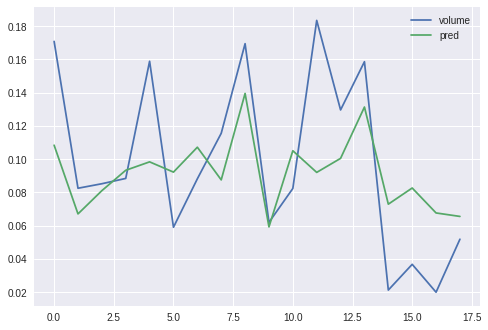

In [0]:
plt.figure()
plt.plot(data_val_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

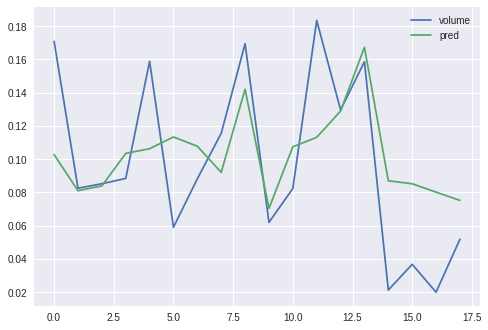

In [0]:
plt.figure()
plt.plot(data_val_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

In [0]:
predictions = model_rnn.predict(data_test_ready[0])

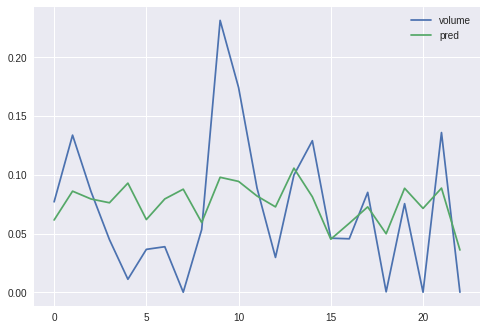

In [0]:
plt.figure()
plt.plot(data_test_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

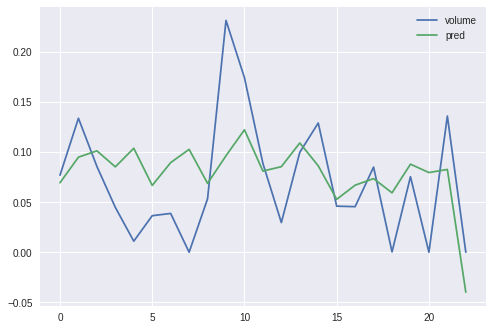

In [0]:
plt.figure()
plt.plot(data_test_ready[1], label='volume')
plt.plot(predictions, label='pred')
plt.legend()

### 2-layer LSTM

In [0]:
def create_stacked_lstm_model(lstm_dims, sequence_length, data_dim, dropout_pct=None, lr=1e-4):
  inputs = Input(shape=(sequence_length, data_dim,), name='input')
  
  temp = inputs
  for lstm_dim in lstm_dims[:-1]:
    temp = LSTM(lstm_dim, return_sequences=True)(temp)
    
    if dropout_pct is not None:
      temp = Dropout(dropout_pct)(temp)
    
  output = LSTM(lstm_dims[-1], return_sequences=False)(temp)
  output = Dense(1)(output)
  
  model = Model(inputs=inputs, outputs=output)
#   model.compile(loss='mse',
#                 optimizer=Adam(lr=lr),
#                 metrics=[r2_keras])
  model.compile(loss=binary_crossentropy,
                optimizer=Adam(lr=lr),
                metrics=['mse', r2_keras])


  model.summary()
  print("lr=%f" % lr)
  return model

In [0]:
stacked_lstm = create_stacked_lstm_model([1, 1], sequence_length, data_train_transformed.shape[1], dropout_pct=0.5, lr=1e-4)
stacked_lstm.fit_generator(data_train_generator,
          steps_per_epoch=200,
          epochs=5,
          verbose=1,
          validation_data=data_val_ready)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 10, 10)            0         
_________________________________________________________________
lstm_41 (LSTM)               (None, 10, 1)             48        
_________________________________________________________________
dropout_16 (Dropout)         (None, 10, 1)             0         
_________________________________________________________________
lstm_42 (LSTM)               (None, 1)                 12        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________
lr=0.000100
Epoch 1/5
200/200 [==============================] - 11s 56ms/step - loss: 3.0720 - mean_squared_error: 0.1062 - r2_keras: -5.9691 - v

In [0]:
stacked_lstm.fit_generator(data_train_generator,
          steps_per_epoch=1000,
          epochs=10,
          verbose=1,
          validation_data=data_val_ready)

Epoch 1/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.6413 - mean_squared_error: 0.0098 - val_loss: 1.3853 - val_mean_squared_error: 0.0037
Epoch 2/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.5446 - mean_squared_error: 0.0083 - val_loss: 1.8671 - val_mean_squared_error: 0.0050
Epoch 3/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4968 - mean_squared_error: 0.0076 - val_loss: 1.8889 - val_mean_squared_error: 0.0050
Epoch 4/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4791 - mean_squared_error: 0.0073 - val_loss: 2.0413 - val_mean_squared_error: 0.0054
Epoch 5/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4622 - mean_squared_error: 0.0070 - val_loss: 2.1160 - val_mean_squared_error: 0.0056
Epoch 6/10
1000/1000 [==============================] - 13s 13ms/step - loss: 0.4491 - mean_squared_error: 0.0068 - val_loss: 2.1147 - val_mean_squared_error: 0.0056
Epoc